In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import category_encoders as ce
# import logging
# logging.basicConfig(level=logging.INFO)


## to specify by user
savepath = '~/Downloads/'

## load and prepare data
sns.get_dataset_names()
df = sns.load_dataset('mpg')
df.dtypes
df.drop('name', axis=1, inplace=True)
if df.isna().any().any():
    df.dropna(inplace=True)

X, y = df.drop('mpg', axis=1), df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## create and fit pipeline
ohe = ce.OneHotEncoder()
rf = RandomForestRegressor()
pipe = make_pipeline(ohe, rf)

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8912038738256421

In [2]:
## setup fippy explainer to explain the model
from fippy.explainers import Explainer
from fippy.samplers import UnivRFSampler, ContUnivRFSampler, SequentialSampler

# create univariate categorical and continuous samplers and compile them to sequential sampler
cat_fs = X_train.select_dtypes(include='object').columns # specify categorical features
cat_sampler = UnivRFSampler(X_train, cat_inputs=cat_fs)
cont_sampler = ContUnivRFSampler(X_train, cat_inputs=cat_fs)
sampler = SequentialSampler(X_train, categorical_fs=cat_fs,
                            cont_sampler=cont_sampler, cat_sampler=cat_sampler)

# create explainer
wrk = Explainer(pipe.predict, X_train, loss=mean_squared_error, sampler=sampler)

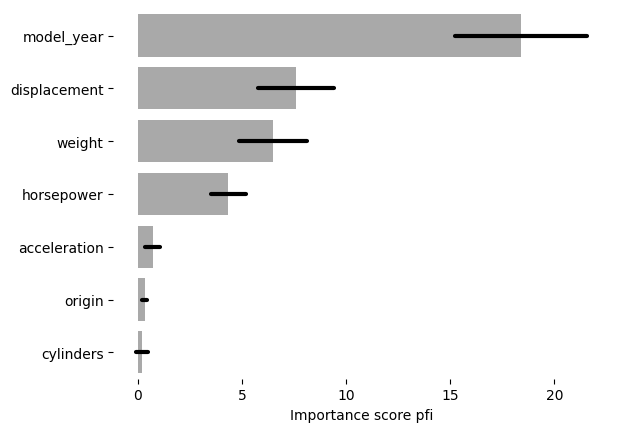

In [3]:
## compute PFI
ex_pfi = wrk.pfi(X_test, y_test)
ex_pfi.hbarplot()
plt.show()

# mean feature importance for each feature (and respective standard deviation)
ex_pfi.fi_means_stds()

# save explanation to csv 
ex_pfi.to_csv(savepath=savepath, filename='pfi.csv')

# load explanation from csv again
from fippy.explanation import Explanation
ex_pfi = Explanation.from_csv(savepath + 'pfi.csv')

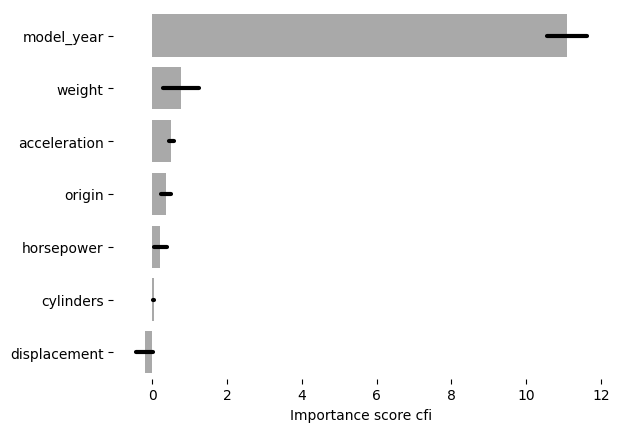

In [4]:
## compute CFI

ex_cfi = wrk.cfi(X_test, y_test)
ex_cfi.hbarplot()
plt.show()

ex_cfi.fi_means_stds()
ex_cfi.to_csv(savepath=savepath, filename='cfi.csv')

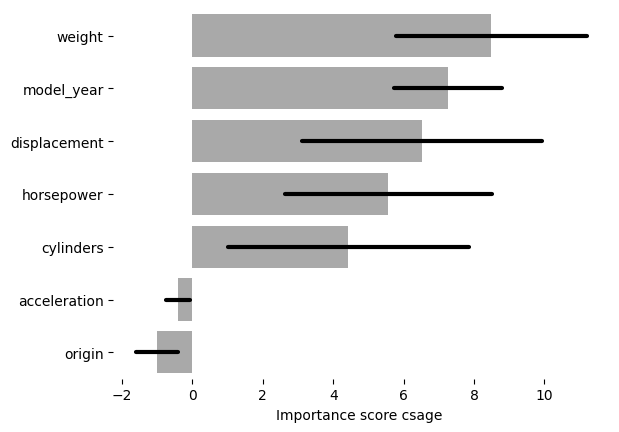

In [5]:
## compute conditional SAGE

ex_csage, sage_orderings = wrk.csage(X_test, y_test, nr_orderings=20, nr_runs=3)
ex_csage.hbarplot()
plt.show()

ex_csage.fi_means_stds()
ex_csage.to_csv(savepath=savepath, filename='csage.csv')

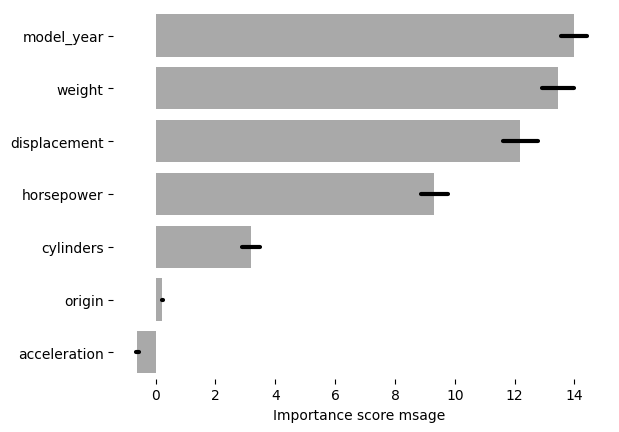

In [6]:
## compute marginal SAGE

ex_msage, sage_orderings = wrk.msage(X_test, y_test, nr_runs=3, detect_convergence=True)
ex_msage.hbarplot()
plt.show()

ex_msage.fi_means_stds()
ex_msage.to_csv(savepath=savepath, filename='msage.csv')